import 需要的包

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import random
from collections import Counter as count
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score


# EDA 探索性数据分析

In [2]:
train = pd.read_csv('data\\ads_train.csv')
test = pd.read_csv('data\\ads_test.csv')
pd.set_option('mode.chained_assignment', None)

In [3]:
test['y_buy']=0
train.columns
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           38209 non-null  int64  
 1   isbuyer              38209 non-null  int64  
 2   buy_freq             1620 non-null   float64
 3   visit_freq           38209 non-null  int64  
 4   buy_interval         38209 non-null  float64
 5   sv_interval          38209 non-null  float64
 6   expected_time_buy    38209 non-null  float64
 7   expected_time_visit  38209 non-null  float64
 8   last_buy             38209 non-null  int64  
 9   last_visit           38209 non-null  int64  
 10  multiple_buy         38209 non-null  int64  
 11  multiple_visit       38209 non-null  int64  
 12  uniq_urls            38209 non-null  int64  
 13  num_checkins         38209 non-null  int64  
 14  y_buy                38209 non-null  int64  
dtypes: float64(5), int64(10)
memory usag

,Unnamed: 0,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
count,38209.000000,38209.000000,1620.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000,38209.000000
mean,19105.000000,0.042398,1.239506,1.868199,0.197411,5.862179,-0.174376,-10.136685,64.657384,64.657384,0.005967,0.277526,86.594624,723.834515,0.004502
std,11030.132554,0.201499,0.840259,2.996675,3.855662,17.726455,4.784059,31.796845,53.453475,53.453475,0.077018,0.447784,61.941089,1286.380572,0.066943
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-181.923800,-187.615600,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000
25%,9553.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18.000000,18.000000,0.000000,0.000000,30.000000,127.000000,0.000000
50%,19105.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,0.000000,0.000000,75.000000,319.000000,0.000000
75%,28657.000000,0.000000,1.000000,2.000000,0.000000,0.125000,0.000000,0.000000,105.000000,105.000000,0.000000,1.000000,155.000000,803.000000,0.000000
max,38209.000000,1.000000,15.000000,84.000000,174.625000,184.916700,84.285710,91.401920,188.000000,188.000000,1.000000,1.000000,206.000000,37091.000000,1.000000


In [2]:
train.head()

NameError: name 'train' is not defined

# EDA完成，数据ETL
类别字段:
isbuyer,multiple_buy,multiple_visit,y_buy

id字段:
unique_urls

数值字段:
buy_freq,visit_freq、buy_interval、sv_interval、expected_time_buy、expected_time_visit、last_buy、last_visit、num_checkins

* y_buy 的平均值 0.004,说明数据集中类别失衡相当严重，只有很少一小部分样本是正样本. 


In [4]:
# 删除id字段，对类别字段转换为onehot编码
train,test = train.drop('uniq_urls',axis=1),test.drop('uniq_urls',axis=1)
train,test = train.drop('Unnamed: 0',axis=1),test.drop('Unnamed: 0',axis=1)
train,test = train.fillna(0),test.fillna(0)

categorical_features = ['isbuyer','multiple_buy','multiple_visit']
train_cat,test_cat = pd.get_dummies(train[categorical_features]),pd.get_dummies(test[categorical_features])
train,test = train.drop(categorical_features, axis=1),test.drop(categorical_features, axis=1)
train,test = pd.concat([train, train_cat], axis=1),pd.concat([test, test_cat], axis=1)

# 分离训练、测试集
train_X,test_X = train.drop('y_buy', axis=1),test.drop('y_buy', axis=1)
train_Y,test_Y = train['y_buy'],test['y_buy']

train_X.head()
test_X.head()



,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,num_checkins,isbuyer,multiple_buy,multiple_visit
0,0.0,1,0.0,0.00000,0.0,0.0000,72,72,1100,0,0,0
1,0.0,1,0.0,0.00000,0.0,0.0000,5,5,12,0,0,0
2,0.0,1,0.0,0.00000,0.0,0.0000,42,42,110,0,0,0
3,0.0,2,0.0,29.79167,0.0,-106.1883,121,121,401,0,0,1
4,0.0,2,0.0,21.33333,0.0,-108.3230,118,118,891,0,0,1


In [5]:
X_resample, Y_resample = RandomOverSampler(random_state=0).fit_resample(train_X, train_Y)

Y_resample.describe()

count    76074.000000
mean         0.500000
std          0.500003
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: y_buy, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split
 
X_train, X_val, Y_train, Y_val = train_test_split(X_resample,Y_resample, test_size=0.2)

In [7]:
# 中位数填充
from sklearn.impute import SimpleImputer
median_imputer=SimpleImputer(strategy='median')
median_imputer.fit(X_train)
median_imputer.fit(X_val)
median_imputer.fit(test_X)

# 按照范围进行比例归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_features = ['buy_freq','visit_freq','buy_interval','sv_interval','expected_time_buy','expected_time_visit','last_buy','last_visit','num_checkins']
X_train[scale_features] = scaler.fit_transform(X_train[scale_features])
X_val[scale_features] = scaler.fit_transform(X_val[scale_features])
test_X[scale_features] = scaler.fit_transform(test_X[scale_features])


In [8]:
X_train.head()



,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,num_checkins,isbuyer,multiple_buy,multiple_visit
1760,-0.323795,-0.445922,-0.19542,-0.461778,0.146699,0.265223,0.642331,0.642331,-0.106442,0,0,0
5973,-0.323795,-0.445922,-0.19542,-0.461778,0.146699,0.265223,-0.756727,-0.756727,-0.214362,0,0,0
13745,-0.323795,-0.323271,-0.19542,1.046112,0.146699,0.652629,-0.835547,-0.835547,-0.382932,0,0,1
40352,-0.323795,0.657942,-0.19542,0.283713,0.146699,0.502102,-0.776432,-0.776432,-0.325850,0,0,1
58348,0.579108,-0.077967,-0.19542,2.395375,0.146699,1.337470,-0.815842,-0.815842,-0.470339,1,0,1


# ETL完成，实验可行性

尝试在进行整理过的数据上，进行逻辑回归

用库函数LR，看下效果

77.73

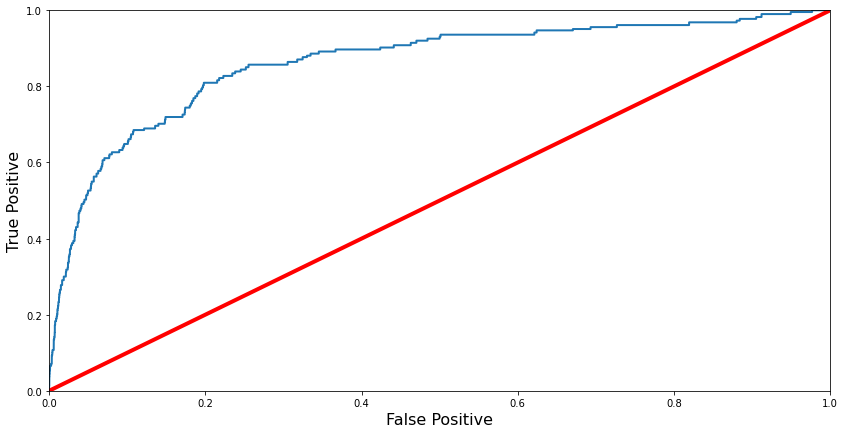

In [9]:
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive', fontsize=16)
    plt.ylabel('True Positive', fontsize=16)

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_val)
Y_scores = logreg.predict_proba(X_val)
Y_scores = Y_scores[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_val,Y_scores)
plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

In [10]:
train_x = X_train.T
samples = train_x.shape[1]
train_y = Y_train.values.reshape((1,samples))
print(train_x.shape)
print(train_y.shape)

(12, 60859)
(1, 60859)


In [11]:
# define hyperparameters
learning_rate = 0.01
num_iter = 5000

# 手动计算普通LR模式

(1, 60859) (12, 60859) (12, 1)


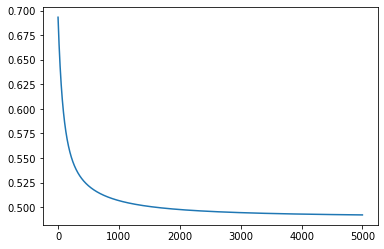

In [12]:
w = np.zeros(shape=(train_x.shape[0],1))
b = 0
print(train_y.shape,train_x.shape,w.shape)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def FpBp(w, b, X, Y):
    """
    传参:
    w -- 权重 shape： (12,1)
    b -- 偏置项,shape(1,1)
    X -- 数据集，shape： (12,m),m为样本数
    Y -- 真实标签，shape： (1,m)
    """
    
    #获取样本数m：
    m = X.shape[1]
    # 前向传播 ：
    assert(w.T.shape[1]==X.shape[0])
    yhat = sigmoid(np.dot(w.T,X))  
    
    assert(yhat.shape == Y.shape)
    cross_entropy_loss = -(np.sum(Y*np.log(yhat)+(1-Y)*np.log(1-yhat)))/m                 
    
    # 反向传播：
    dZ = yhat-Y
    dw = (np.dot(X,dZ.T))/m
    db = (np.sum(dZ))/m  
    
    #返回值：
    return dw,db,cross_entropy_loss

    
loss = []


for i in range(num_iter):
    dw,db,cost = FpBp(w,b,train_x,train_y)
    w = w - learning_rate*dw
    b = b - learning_rate*db
    loss.append(cost)

plt.plot(loss)



In [13]:
def Predict(w,b,X):
    return sigmoid(np.dot(w.T,X))

pred_probs = Predict(w,b,X_val.T)
pred_labels = np.where(pred_probs>0.5,1,0)
diff = Y_val.values-pred_labels[0]
acc = 1-np.sum(np.abs(diff))/len(diff)
acc


0.8106473874465987

测试集验证结果基本符合库函数的结果，实验视为成功

# FL cross-device模式

假设cross-device中心化模式，6万条数据分散于10个client（非IID分布）

FL按轮进行，每轮随机选中5个client，训练完成后global模型更新，global参数作为下一轮的起始参数进行下发。



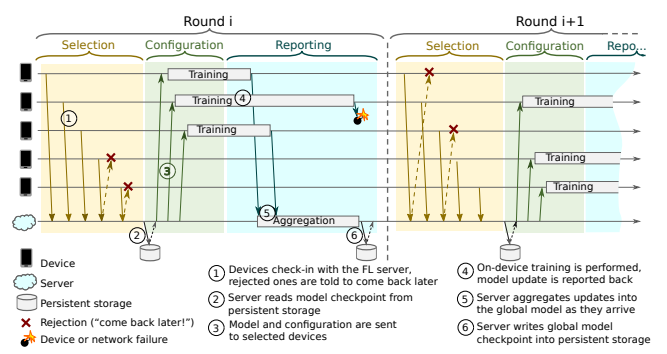

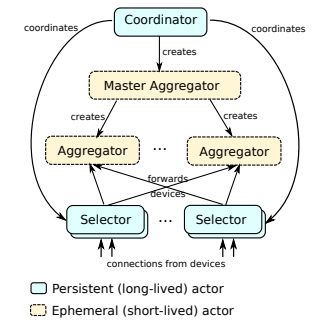

In [14]:
train_X.shape

(38209, 12)

## 非IID切分数据

针对x的任意一个维度进行排序，然后顺序从排序后的记录中依次取值。这样得出的数据分布，和整体的数据分布就是非iid的关系。

ClientData模拟各个客户端持有的隐私数据。 

In [15]:
class Client:
    def __init__(self,id,train_x,train_y):
        self.client_id = id
        self.train_X = np.array(train_x).T
        self.train_Y = np.array(train_y).T
        self.sampleCount = self.train_X.shape[1]
        self.losses = []
        print("Client initialized with {} rows of data".format(self.sampleCount))

    def RunOptimization(self,w,b,iteration,learning_rate,showDetails=False):
        local_w = w
        local_b = b
        localDw = np.zeros(shape=w.shape)
        localDb = 0
        
        for i in range(iteration):
            m = self.train_X.shape[1]
            # 前向传播 ：
            assert(w.T.shape[1]==self.train_X.shape[0])
            yhat = sigmoid(np.dot(w.T,self.train_X))  
    
            assert(yhat.shape == self.train_Y.shape)
            cross_entropy_loss = -(np.sum(self.train_Y*np.log(yhat)+(1-self.train_Y)*np.log(1-yhat)))/m                 
    
            # 反向传播：
            dZ = yhat-self.train_Y
            dw = (np.dot(self.train_X,dZ.T))/m
            db = (np.sum(dZ))/m  
            local_w -= learning_rate*dw
            local_b -= learning_rate*db
            localDw += dw
            localDb += db
            self.losses.append(cross_entropy_loss)
            if showDetails:
                print("Client{},iter{} finished".format(self.client_id,i))
        if showDetails:
            print(localDw,localDb)
            
        return localDw,localDb

iid_y = pd.DataFrame(data=train_y.T,columns=["y_buy"])
iid_x = train_x.T
iid_union = [(iid_x.values[i],iid_y.values[i]) for i in range(iid_x.shape[0])]

iid_union.sort(key=lambda x:x[0][9])
noniid_x = [x[0] for x in iid_union]
noniid_y = [x[1] for x in iid_union]

np.array(noniid_x).T.shape

(12, 60859)

In [16]:
clients = [
    Client(1,noniid_x[:500],noniid_y[:500]),
    Client(2,noniid_x[500:6500],noniid_y[500:6500]),
    Client(3,noniid_x[6500:13000],noniid_y[6500:13000]),
    Client(4,noniid_x[13000:20000],noniid_y[13000:20000]),
    Client(5,noniid_x[20000:26000],noniid_y[20000:26000]),
    Client(6,noniid_x[26000:35000],noniid_y[26000:35000]),
    Client(7,noniid_x[35000:42000],noniid_y[35000:42000]),
    Client(8,noniid_x[42000:48000],noniid_y[42000:48000]),
    Client(9,noniid_x[48000:54000],noniid_y[48000:54000]),
    Client(10,noniid_x[54000:],noniid_y[54000:]),
]

Client initialized with 500 rows of data
Client initialized with 6000 rows of data
Client initialized with 6500 rows of data
Client initialized with 7000 rows of data
Client initialized with 6000 rows of data
Client initialized with 9000 rows of data
Client initialized with 7000 rows of data
Client initialized with 6000 rows of data
Client initialized with 6000 rows of data
Client initialized with 6859 rows of data


创建控制类，持有所有客户端的列表。

和客户端之间按轮进行通信。每轮的工作如下：

- 随机从所有客户端中选择5个，下发当前global的w和b
- 命令客户端进行若干论FP和BP（FedAvg）
- 收集各个客户端更新的w和b梯度矩阵，聚合并更新global w和b
- 聚合和更新完成后，开启下一轮

In [17]:
class Coordinator:
    def __init__(self,clients,shape):
        self.clients = clients
        self.global_w = np.zeros(shape=(shape[0],1))
        self.global_b = 0
        self.lr = 0.01
        
    def ProcessRound(self,clientsNeeded,localIter,showDetails=False):
        selected_clients = random.sample(self.clients,clientsNeeded)
        grads = [x.RunOptimization(self.global_w,self.global_b,localIter,self.lr,showDetails) for x in selected_clients]
        grad_w = [x[0] for x in grads]      
        grad_b = [x[1] for x in grads]
        aggregated_dw = np.zeros(shape=(self.global_w.shape[0],1))
        aggregated_db = 0
        
        for i in range(clientsNeeded):
            aggregated_dw+=grad_w[i]
            aggregated_db+=grad_b[i]
        aggregated_dw/=clientsNeeded
        aggregated_db/=clientsNeeded
        self.global_w-=aggregated_dw*self.lr
        self.global_b-=aggregated_db*self.lr
    
    def FedAvg(self,rounds):
        for i in range(rounds):
            self.ProcessRound(5,5,False)
        
sample_data = np.zeros(shape=(12,1))
coordinator = Coordinator(clients,sample_data.shape)
coordinator.ProcessRound(1,1,True)
coordinator.FedAvg(200)

Client5,iter0 finished
[[-0.03205573]
 [-0.11342398]
 [-0.01934663]
 [-0.03126229]
 [ 0.01452318]
 [-0.03880013]
 [ 0.21150169]
 [ 0.21150169]
 [ 0.04538854]
 [ 0.        ]
 [ 0.        ]
 [-0.0505    ]] 0.099


In [18]:
pred_probs = Predict(coordinator.global_w,coordinator.global_b,X_val.T)
pred_labels = np.where(pred_probs>0.5,1,0)
diff = Y_val.values-pred_labels[0]
acc = 1-np.sum(np.abs(diff))/len(diff)
acc

0.8002628984554716

In [19]:
coordinator.global_w

array([[ 0.82890803],
       [ 1.04614959],
       [ 0.19002162],
       [-0.15537406],
       [-0.1233623 ],
       [-0.06161777],
       [-0.42049912],
       [-0.42049912],
       [-0.1004854 ],
       [ 0.44917893],
       [ 0.01854208],
       [ 0.62457012]])

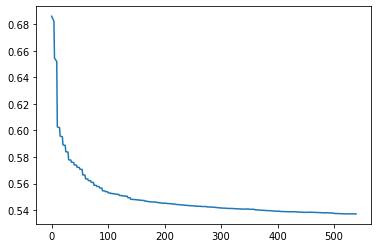

In [20]:
plt.plot(coordinator.clients[1].losses)

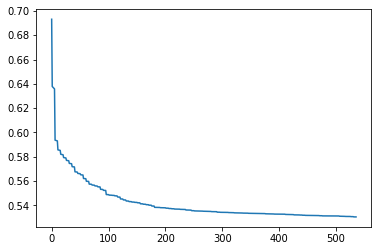

In [21]:
plt.plot(coordinator.clients[4].losses)